<a href="https://colab.research.google.com/github/edologgerbird/deep-learning-project/blob/develop/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Caption Generator: Comparing the performance between LSTM and Transformer based models

Project by: Loh Hong Tak Edmund (S221545), Sim Wee Yang (S221547), Woo Jun Hao Bryan (S221526)


### Background

Image caption generation is the process of a computer being able to recognize the context of an image and annotating it with the relevant captions. Recent developments in artificial intelligence and natural language processing allowed image caption generation to gain traction amongst researchers. The applications of image captioning are extensive, and there are various related methods that allow us to achieve this task. We intend to narrow our research down to LSTMs, transformers and the attention mechanism.

This project aims to compare the performance of an LSTM-based model with that of a transformer-based model on the task of image caption generation. The project will employ performance metrics BLEU (Bilingual Evaluation Understudy) Score and Rouge (Recall Oriented Understudy for Gisting Evaluation) to identify the best performing model (Dayal, 2022).

### Flickr8k

This project will explore Image Caption Generation using the Flickr8k dataset, which is a benchmark collection for sentence-based image description and search. This set contains 8,000 images that are each paired with five different captions which describes the entities and events within each respective picture.

### Setting Up Environment



Importing relevant modules

In [ ]:
# !pip install great_expectations

In [35]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

import great_expectations as ge

import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

# import data_utils

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Setting up Google Drive for development on Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
drive_path = 'drive/My Drive/'

### Loading the data

We first start by loading the data, where we consolidate the image file names present in the data set. We also load the captions file, which contains the 5 captions tagged to their respective images.

In [4]:
image_paths = glob.glob(f'{drive_path}data/flickr_8k_dataset/Images/*.jpg')
print("Total Images:\t", len(image_paths))

captions = pd.read_csv(f'{drive_path}data/flickr_8k_dataset/captions.txt')
images = [f'{drive_path}data/flickr_8k_dataset/Images/{i}' for i in captions.image.values]

print(images[:3])
captions.head()

Total Images:	 8091
['drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg']


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


### Data Sanity Check

Next, we perform preliminary data sanity checks to ensure the cleanliness and validity of the data. We will make use of the great_expectations (GE) package to assist in these checks.

In summary, we will perform the following checks:

1. No null values
2. Caption data are of appropriate types
3. No images listed in the captions file that are missing in the images folder, vice versa
4. Each image contains exactly 5 accompanying captions

In [27]:
def check_expectations(df, column, expectation):
  ge_df = ge.from_pandas(df)
  ge_result = ge_df.expect_column_values_to_be_in_set(column, expectation)

  return {
    "Outcome: ": ge_result["success"],
    "Results: ": ge_result["result"]
    }

In [33]:
assert(set(captions["image"]) == set([i.split("/")[-1] for i in image_paths]))

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
check_expectations(captions, "image", [i.split("/")[-1] for i in image_paths])

{'Outcome: ': True,
 'Results: ': {'element_count': 40455,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

In [31]:
caption_counts = captions.groupby("image").count()

check_expectations(caption_counts, "caption", [5])

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Outcome: ': True,
 'Results: ': {'element_count': 8091,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

Data passes sanity checks. There are no null and missing values, and the columns contain the expected image files names and the number of accomanying captions per image.

### Visualising the Data



First, we would like to visualise a few sample images.

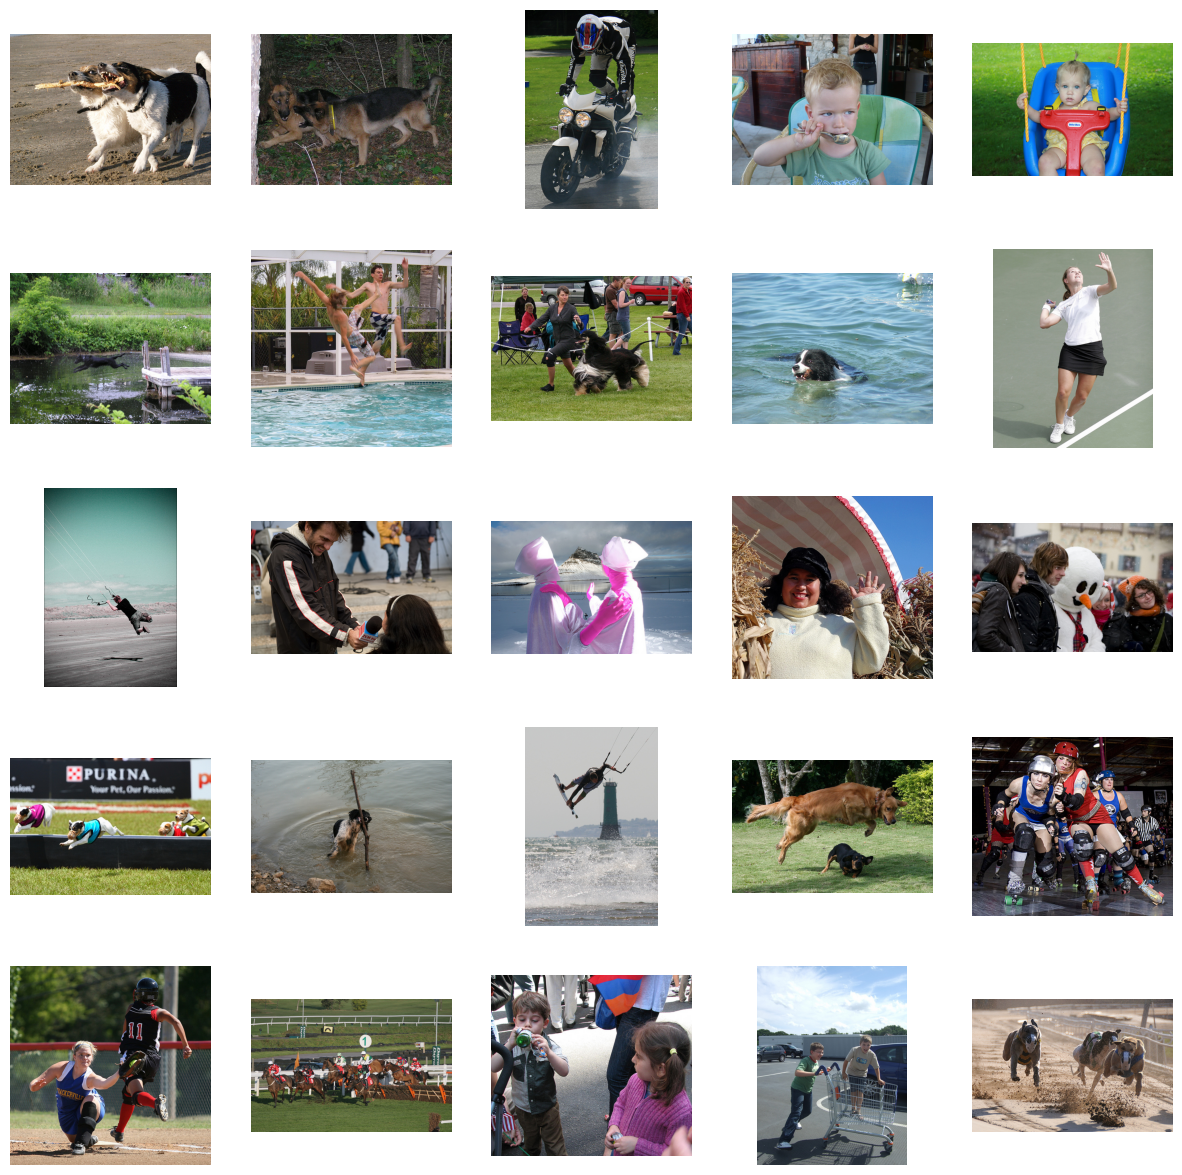

In [116]:
n_samples = 5*5
sample_images_path = random.sample(image_paths,n_samples)
sample_images_name = [i.split('/')[-1] for i in sample_images_path] 

fig = plt.figure(figsize=(15, 15))

columns = 5
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')
  


Next, we would like to view a sample image and its accompanying captions.

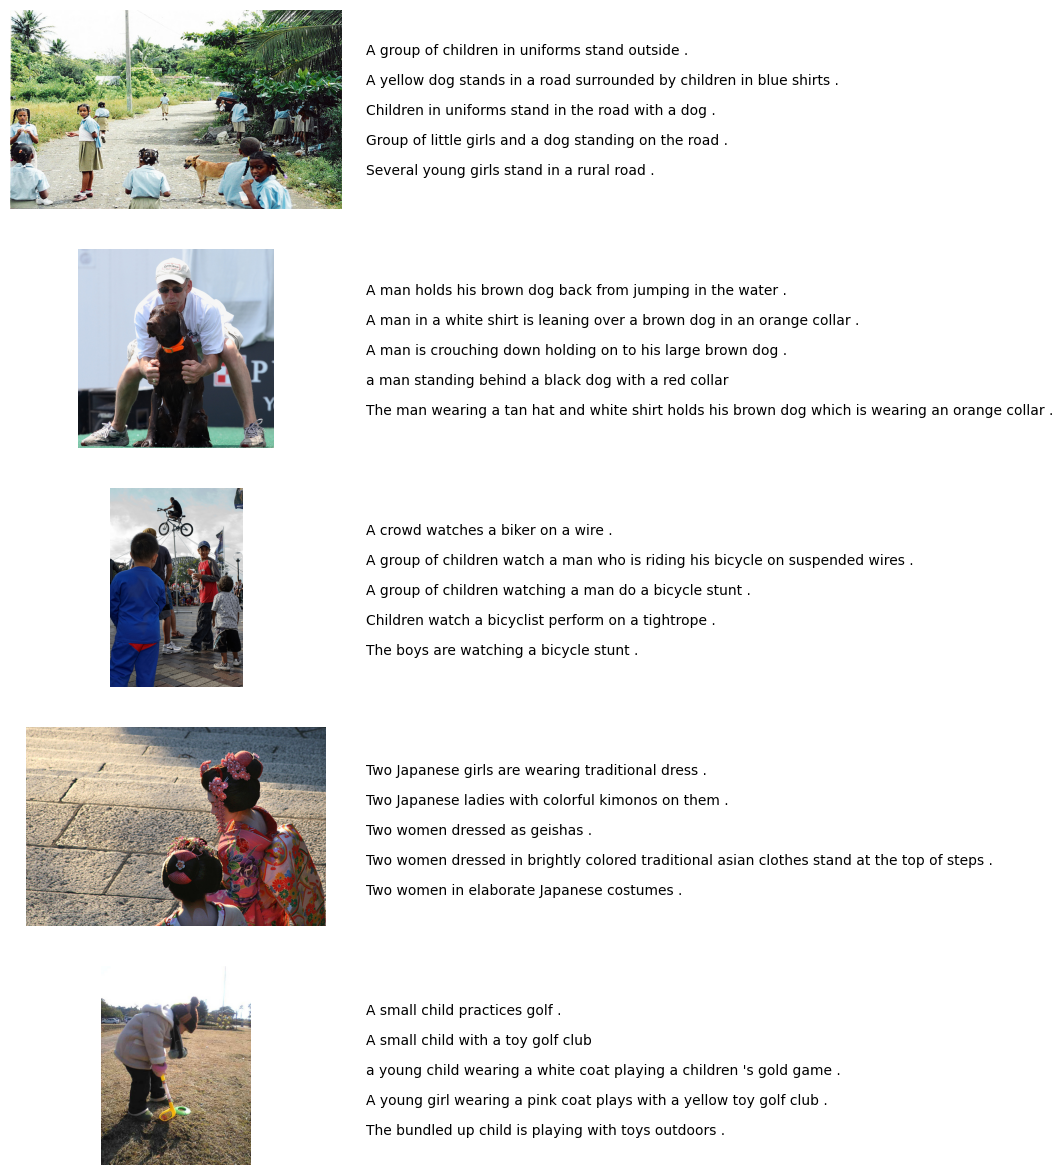

In [117]:
n_samples = 5
sample_images_path = random.sample(image_paths,n_samples)
sample_images_name = [i.split('/')[-1] for i in sample_images_path] 
sample_images_captions = {i:captions[captions["image"] == i]["caption"].values for i in sample_images_name}

fig = plt.figure(figsize=(8, 15))

columns = 1
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')
  for enum, caption in enumerate(sample_images_captions[sample_images_name[i]]):
    plt.figtext(0.75,0.85+i*-0.16-0.02*enum, caption)